In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi':200, 'bbox_inches': 'tight'}
from matplotlib_latex_configurations import *
rcParams['figure.figsize'] = (one_column_figure_size * golden_ration, one_column_figure_size)

import numpy as np
import networkx as nx
import scipy as sc
import pylab as plt
from tqdm import tqdm
import scipy.interpolate as sci
import networkx as nx
import pickle
import itertools
marker = itertools.cycle(('p', '+', '.', 'o', '*', 's', 'v'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Phase transition

(0, 1.5)

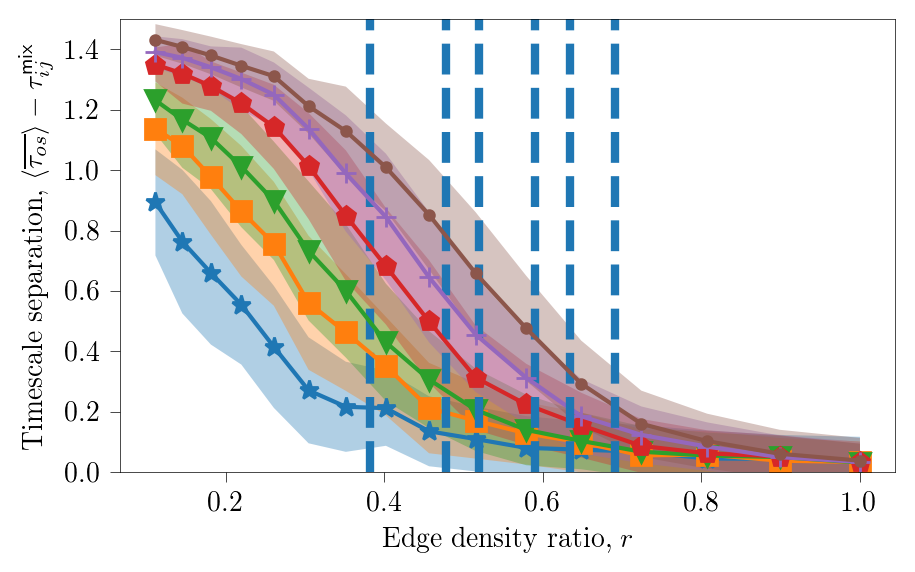

In [23]:
import pickle
cases = 16
n = 200

times = np.logspace(-2, 2., 50)

c = [5, 8, 10, 15, 20, 30] #average degree

fig, ax2= plt.subplots(figsize=(5,3))
ax2.set_xlabel(r'Edge density ratio, $r$')
ax2.set_ylabel(r'Timescale separation, $\langle \overline{\tau_{os}} \rangle - \tau^\mathsf{mix}_{ij}$')

def plot_phase_transition(r, osmean, osstd, ax2):

    f = sci.interp1d(np.arange(len(times)), times)
    ostime = np.log10(f(osmean[:,0]))
    mixtime = np.log10(f(osmean[:,1]))
    
    ostimestd = ostime - np.log10(f(osmean[:,0] - osstd[:,0]))
    mixtimestd = mixtime - np.log10(f(osmean[:,1] - osstd[:,1]))
    
    mean = np.abs(mixtime - ostime)
    std = np.sqrt((ostimestd/ostime)**2 + (mixtimestd/mixtime)**2)
    
    ax2.plot(r, mean,'-o', marker = next(marker), markersize=7)
    ax2.fill_between(r, mean + std, mean -std, alpha=0.35)

    ax2.axvline((c_ - np.sqrt(c_))/(c_ + np.sqrt(c_)), c='C0',lw=3,ls='--')
    
    gplus = sci.interp1d(mean + std, r)
    g = sci.interp1d(mean, r)
    gminus = sci.interp1d(mean-std, r)
    
    th = 0.2
    
    return [gminus(th), g(th), gplus(th)]


rc = []
for c_ in c:

    c_in = np.linspace(c_*0.5, c_*0.9, cases)
    c_out = c_ - c_in
    r = c_out/c_in
    
    os = pickle.load(open("/data/AG/geocluster/phase_transition/phase_transition_final_k" + str(c_) + "_"+str(n)+".pkl", "rb"))
    osmean = np.nanmean(np.array(os),0)
    osstd = np.nanstd(np.array(os),0)

    intersection = plot_phase_transition(r, osmean, osstd, ax2)
    rc.append(intersection)
    
ax2.set_ylim([0, 1.5])    
#ax2.legend([r'$\bar{k}=8$', r'$\bar{k}=10$', r'$\bar{k}=12$', r'$\bar{k}=15$', r'$\bar{k}=20$', r'$\bar{k}=30$'])    
#plt.savefig('pt_overshoot.svg')    

# Curvature

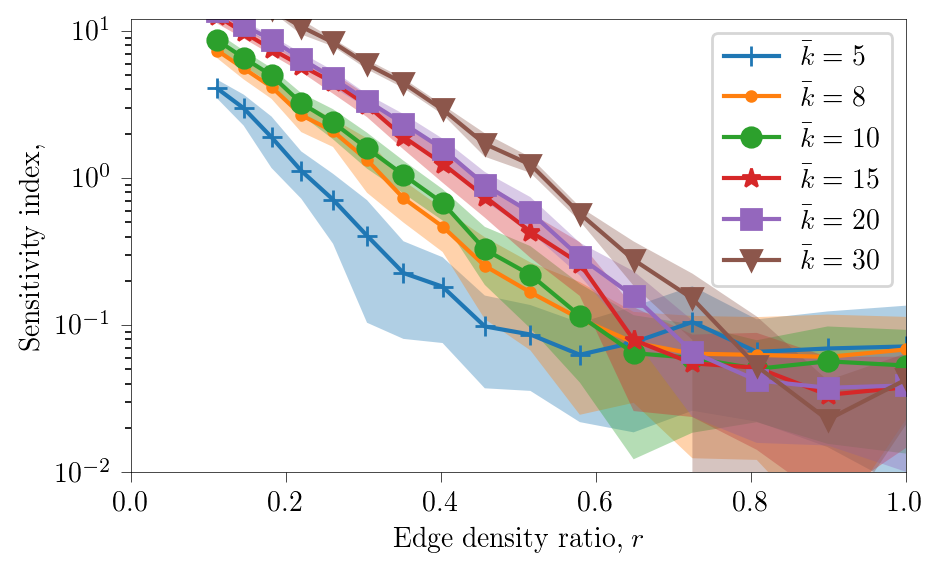

In [18]:
import pickle
import math

cases = 16
times = np.logspace(-2, 2., 25)

fig, ax2 = plt.subplots(figsize=(5,3))

def plot_phase_transition(r, kappamin_avg, kappamin_std, ax2):

    mean = np.array(kappamin_avg)
    std = np.array(kappamin_std)
    
    ax2.plot(r, mean, '-o', marker = next(marker), markersize=7)
    
    ax2.fill_between(r, mean + std, mean - std, alpha=0.35)
    
    #ax2.axvline((c_ - np.sqrt(c_))/(c_ + np.sqrt(c_)), c='C0',lw=3,ls='--')
    

def compute_intersection(r, kappamin_avg, kappamin_std):
    
    mean = np.array(kappamin_avg)
    std = np.array(kappamin_std)
    
    gplus = sci.interp1d(mean + std, r)
    g = sci.interp1d(mean, r)
    gminus = sci.interp1d(mean - std, r, fill_value="extrapolate")
    th = 0.2
    
    return [ gminus(th), g(th), gplus(th)]
    

def compute_separation(graph, kappa):
    kappa_within = []
    kappa_between = []
    for i, e in enumerate(graph.edges):
        if e[0]<n/2 and e[1]>=n/2:
            kappa_between.append(kappa[:,i])
        else:
            kappa_within.append(kappa[:,i])
        
    kappa_within_mean = np.mean(kappa_within, axis=0)
    kappa_between_mean = np.mean(kappa_between, axis=0)
    kappa_within_var = np.var(kappa_within, axis=0)
    kappa_between_var = np.var(kappa_between, axis=0)
    
    #f = sci.interp1d(times, kappa_within_mean)
    #g = sci.interp1d(times, kappa_between_mean)
    indx = np.where(kappa_within_mean>=0.75)[0][0]
    
    #plt.plot(np.log10(times), kappa_within_mean)
    #plt.scatter(np.log10(times[indx]), kappa_within_mean[indx])
    #import sys
    #sys.exit()

    return abs(kappa_within_mean[indx]- kappa_between_mean[indx])/np.sqrt(0.5*(kappa_within_var[indx] + kappa_within_var[indx]))


def compute_separation2(lambda2, times, kappa):
    
    kappamean = 0
    for e in range(kappa.shape[1]):
        f = sci.interp1d(times, kappa[:,e])
        kappamean += f(lambda2)

    kappamean /= kappa.shape[1]
    
    return kappamean


rc2 = []
for c_ in c:

    c_in = np.linspace(c_*0.5, c_*0.9, cases)
    c_out = c_ - c_in
    r = c_out/c_in
    
    a = pickle.load(open("/data/AG/geocluster/phase_transition/phase_transition_curvature_final_k" + str(c_) + "_200.pkl", "rb"))

    kappamin_avg = []
    kappamin_std = []
    zerocross_avg = []
    for case in range(cases):
        
        #select successful trials
        ntrials = len(a)
        kappa = [a[trial][case][1] for trial in range(ntrials) if not np.isnan(a[trial][case][1]).any()]
        graphs = [a[trial][case][0] for trial in range(ntrials) if not np.isnan(a[trial][case][1]).any()]
        
        kappamin = [compute_separation(graphs[i], kappa[i]) for i in range(len(kappa))] 
        #kappamin = [compute_separation2(lambda2, times, kappa[i]) for i in range(len(kappa))] 
                
        #average over them
        kappamin_avg.append(np.mean(kappamin))
        kappamin_std.append(np.std(kappamin))
       
    plot_phase_transition(r, kappamin_avg, kappamin_std, ax2)
    intersection = compute_intersection(r, kappamin_avg, kappamin_std)
    rc2.append(intersection)
    
ax2.set_xlabel(r'Edge density ratio, $r$')
ax2.set_ylabel(r'Sensitivity index, ')
ax2.set_xlim([0, 1])
ax2.set_ylim([0.01, 12])
ax2.set_yscale('log')

ax2.legend([r'$\bar{k}=5$', r'$\bar{k}=8$', r'$\bar{k}=10$', r'$\bar{k}=15$', r'$\bar{k}=20$', r'$\bar{k}=30$'])
#plt.savefig('pt_curvature.svg')

/home/gosztolai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


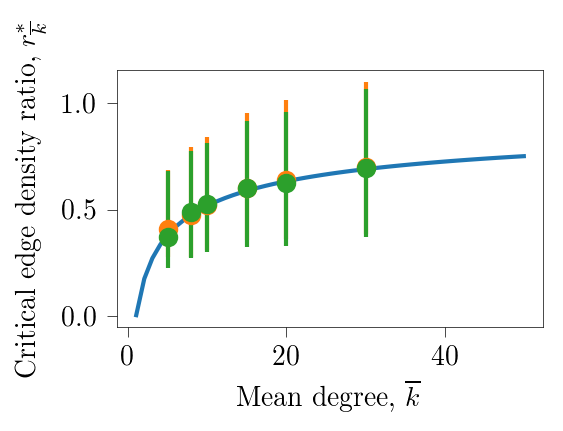

In [13]:
k = np.linspace(0,50)
rcrit = (k - np.sqrt(k))/(k + np.sqrt(k))

plt.plot(k, rcrit)

plt.errorbar(c, np.array(rc)[:,1], yerr=np.array(rc)[:,[0,2]].T/2, fmt='o')
plt.errorbar(c, np.array(rc2)[:,1], yerr=np.array(rc2)[:,[0,2]].T/2, fmt='o')

plt.xlabel(r'Mean degree, $\overline{k}$')
plt.ylabel(r'Critical edge density ratio, $r_{\overline{k}}^*$')
#plt.savefig('critical_density.svg')